In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime

In [192]:
from google.colab import drive
drive.mount('/content/drive') #подключаем гугл коллаб

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [193]:
values = pd.read_csv('/content/drive/My Drive/EkoNiva/value_ver3.csv', encoding='1251', sep=';', decimal=',')
works = pd.read_csv('/content/drive/My Drive/EkoNiva/works_ver3.csv', encoding='1251', sep=';', decimal=',')
fields = pd.read_csv('/content/drive/My Drive/EkoNiva/fields_ver3.csv', encoding='1251', sep=';', decimal=',')
fields.shape, works.shape, values.shape

((16060, 18), (174683, 20), (170813, 8))

In [194]:
works['start_date'] = works['start_date'].map(lambda x : datetime.datetime.strptime(x, "%d.%m.%Y") if type(x) == str else x)
works['end_date'] = works['end_date'].map(lambda x : datetime.datetime.strptime(x, "%d.%m.%Y") if type(x) == str else x)

Работаем чисто с works

In [195]:
works.head()

,season,field,work_type,work_subtype,start_date,end_date,area,main_tech,add_tech,mech,proc_depth,prod_purpose,prod_weight,Unnamed: 13,Unnamed: 14,prod_dry_perc,prod_humid,prod_impur,yield_fact,work_id
0,2023,16.13.12.044.00,Обработка почвы,Боронование,2022-04-29,2022-04-30,"49,78","Трактор колесный Fendt 936 Vario, гос.ном. 050...",Арендованная техника,Ахметсафин Айрат Рафикович,10.0,NaN,0.0,ИСТИНА,"0,00",NaN,NaN,NaN,0.0,A06AD38A-5448-40EC-B095-4B8918B4AC10
1,2023,16.13.12.017.00,Обработка почвы,Боронование,2022-05-01,2022-05-02,"154,76","Трактор колесный Птз К-744Р4, гос.ном. 2251АА1...","Борона зубовая Veles АГС-22-2У.М, зав.ном. 789",Ямалетдинов Фарид Расыхович,10.0,NaN,0.0,ИСТИНА,"0,00",NaN,NaN,NaN,0.0,62B13DCE-FFB5-4E7A-8F1B-88930BD338EF
2,2023,16.13.12.012.00,Обработка почвы,Боронование,2022-05-02,2022-05-03,"40,62","Трактор колесный Fendt 936 Vario, гос.ном. 050...",Арендованная техника,Мухаметзянов Ринат Айратович,10.0,NaN,0.0,ИСТИНА,"0,00",NaN,NaN,NaN,0.0,D5884A6D-4710-4C0A-8E5A-878291B89846
3,2023,16.13.12.012.00,Обработка почвы,Боронование,2022-05-02,2022-05-03,"86,00","Трактор колесный Птз К-744Р4, гос.ном. 2251АА1...","Борона зубовая Veles АГС-22-2У.М, зав.ном. 789",Шакиров Ринат Галиевич,10.0,NaN,0.0,ИСТИНА,"0,00",NaN,NaN,NaN,0.0,7A504837-1127-4315-ACF1-171AC80111BF
4,2023,16.13.12.017.00,Обработка почвы,Боронование,2022-05-02,2022-05-03,"76,00","Трактор колесный Птз К-744Р4, гос.ном. 2251АА1...","Борона зубовая Veles АГС-22-2У.М, зав.ном. 789",Шакиров Ринат Галиевич,10.0,NaN,0.0,ИСТИНА,"0,00",NaN,NaN,NaN,0.0,7FE86DA8-614B-4EBE-85CB-6AF80C08689F


In [196]:
works.drop_duplicates(subset=['field', 'start_date', 'end_date', 'main_tech', 'add_tech']).shape

(158046, 20)

In [197]:
works.isna().sum()

,0
season,0
field,0
work_type,0
work_subtype,0
start_date,0
end_date,9004
area,0
main_tech,0
add_tech,48540
mech,0


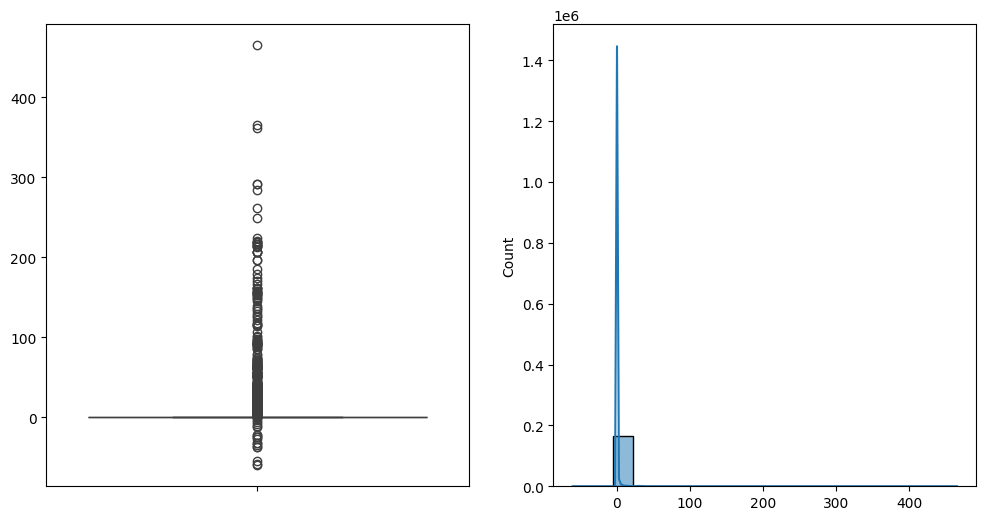

In [198]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
# Убедитесь, что колонки являются форматами datetime
works['start_date'] = pd.to_datetime(works['start_date'])
works['end_date'] = pd.to_datetime(works['end_date'])
duration = works['end_date'] - works['start_date']
duration_days = duration.dt.total_seconds() / 86400  # Получаем число в днях
sns.boxplot(duration_days, ax=ax[0])
sns.histplot(duration_days, ax=ax[1], kde=True)
plt.show()

In [199]:
works_1 = works[(works['end_date'] - works['start_date']).dt.total_seconds() / 86400 > 31].copy()
works_1['work_type'].value_counts()

,count
work_type,
Обработка почвы,128
Уборка,84
Внесение удобрений,58
Внесение СЗР,16
Сев,16


In [200]:
works = works.drop_duplicates(subset=['field', 'start_date', 'end_date', 'main_tech', 'add_tech'])
works['start_date'] = works.apply(lambda x:x.start_date if 0 <= (x.end_date - x.start_date).days <= 31 else np.nan, axis=1)
#print(works['start_date'].isna().sum())
#meann, iqr = duration_days.mean(), 3 * (duration_days.quantile(0.75) - duration_days.quantile(0.25))
duration_days = (works['end_date'] - works['start_date']).dt.total_seconds() / 86400
max_zn = duration_days.quantile(0.99)
works['start_date'] = works.apply(lambda x:x.start_date if (x.end_date - x.start_date).days <= max_zn else np.nan, axis=1)
#print(works['start_date'].isna().sum())
works = works.dropna(subset=['end_date', 'start_date'])
works.shape

(149189, 20)

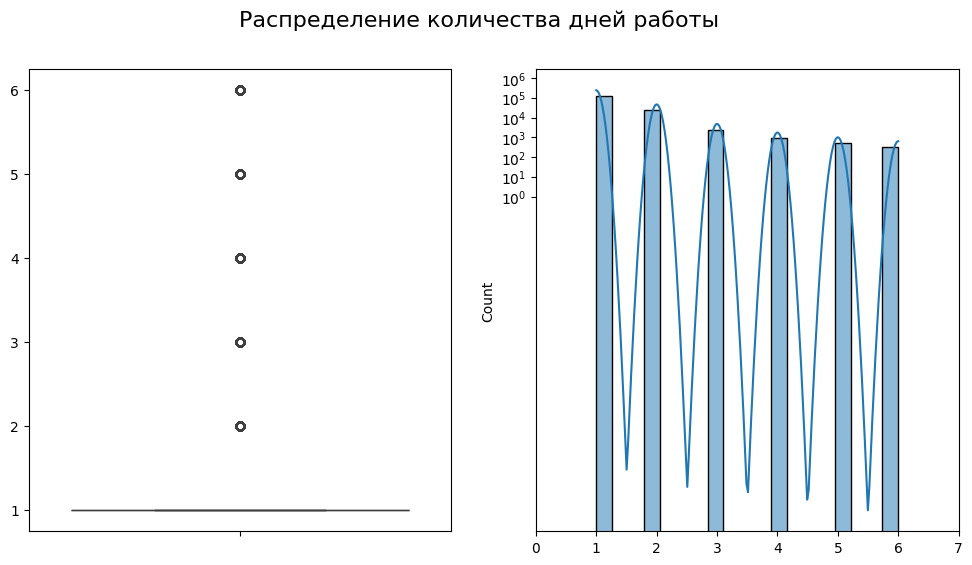

In [201]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.suptitle('Распределение количества дней работы', fontsize=16)
duration = works['end_date'] - works['start_date']
duration_days = duration.dt.total_seconds() / 86400 + 1 # Получаем число в днях
sns.boxplot(duration_days, ax=ax[0])
sns.histplot(duration_days, ax=ax[1], kde=True)
plt.xticks(np.arange(0, 8, 1))
plt.yscale('log')
plt.yticks([10 ** i for i in np.arange(0, 7, 1)])
plt.show()

In [202]:
works['mech'].map(lambda x: x.split()[1]).value_counts()

,count
mech,
Александр,19568
Сергей,18384
Алексей,12680
Владимир,10400
Николай,7455
...,...
Райнгольд,2
Раиль,1
Умеджон,1


In [208]:
fields['id'] = fields['season'].map(str)+' '+fields['field'].map(str)
works['id'] = works['season'].map(str)+' '+works['field'].map(str)
merged_works = works.merge(fields, on='id', how='left')
merged_works = merged_works.drop(columns=['area_y', 'hybrid', 'reproduction',	'seed_origin',	'technology', 'crop_predecessor'	,'crop_yearold', 'fertility_score', 'season_y',
                                          ''])
merged_works.head(20)

,season_x,field_x,work_type,work_subtype,start_date,end_date,area_x,mech,proc_depth,prod_purpose,...,yield_fact,work_id,region,land_type,crop,yield_plan,p2o5,k2o,humus,ph
0,2023,16.13.12.044.00,Обработка почвы,Боронование,2022-04-29,2022-04-30,"49,78",Ахметсафин Айрат Рафикович,10.0,NaN,...,0.0,A06AD38A-5448-40EC-B095-4B8918B4AC10,Татарстан,пашня,Лён масличный,1.24,197.67,192.33,6.0,5.63
1,2023,16.13.12.017.00,Обработка почвы,Боронование,2022-05-01,2022-05-02,"154,76",Ямалетдинов Фарид Расыхович,10.0,NaN,...,0.0,62B13DCE-FFB5-4E7A-8F1B-88930BD338EF,Татарстан,пашня,Гречиха,1.53,211.50,196.42,8.0,6.13
2,2023,16.13.12.012.00,Обработка почвы,Боронование,2022-05-02,2022-05-03,"40,62",Мухаметзянов Ринат Айратович,10.0,NaN,...,0.0,D5884A6D-4710-4C0A-8E5A-878291B89846,Татарстан,пашня,Подсолнечник,1.70,225.00,196.67,7.8,6.67
3,2023,16.13.12.012.00,Обработка почвы,Боронование,2022-05-02,2022-05-03,"86,00",Шакиров Ринат Галиевич,10.0,NaN,...,0.0,7A504837-1127-4315-ACF1-171AC80111BF,Татарстан,пашня,Подсолнечник,1.70,225.00,196.67,7.8,6.67
4,2023,16.13.12.017.00,Обработка почвы,Боронование,2022-05-02,2022-05-03,"76,00",Шакиров Ринат Галиевич,10.0,NaN,...,0.0,7FE86DA8-614B-4EBE-85CB-6AF80C08689F,Татарстан,пашня,Гречиха,1.53,211.50,196.42,8.0,6.13
5,2023,16.13.12.012.00,Обработка почвы,Боронование,2022-05-24,2022-05-25,"126,62",Шакиров Ринат Галиевич,5.0,NaN,...,0.0,563C6ECC-25A7-4EAE-8F0F-C989DE97FBBF,Татарстан,пашня,Подсолнечник,1.70,225.00,196.67,7.8,6.67
6,2023,16.13.12.044.00,Обработка почвы,Боронование,2022-05-24,2022-05-24,"49,78",Шакиров Ринат Галиевич,5.0,NaN,...,0.0,D0CCCE21-598B-4D33-91AC-9D863F9A2A81,Татарстан,пашня,Лён масличный,1.24,197.67,192.33,6.0,5.63
7,2023,16.13.12.017.00,Обработка почвы,Боронование,2022-05-25,2022-05-26,"137,00",Ямалетдинов Фарид Расыхович,5.0,NaN,...,0.0,41C5D7A7-ECE4-4D1B-8B23-6864CB9BF7F0,Татарстан,пашня,Гречиха,1.53,211.50,196.42,8.0,6.13
8,2023,16.13.12.017.00,Обработка почвы,Боронование,2022-05-26,2022-05-26,"98,76",Шакиров Ринат Галиевич,5.0,NaN,...,0.0,787AF733-9B86-48D1-AAA5-C0074BF011D7,Татарстан,пашня,Гречиха,1.53,211.50,196.42,8.0,6.13
9,2023,40.22.02.002.00,Обработка почвы,Дискование,2022-06-01,2022-06-01,"30,20",Малкоч Иван Васильевич,5.0,NaN,...,0.0,F1D079E2-0CB3-48F4-BC55-4B207411B271,Калуга,пашня,Оз.пшеница мягкая,4.85,NaN,NaN,NaN,NaN
